# Modelo Complejo - Datos Balanceados
En este notebook se encuentra el proceso de entrenamiento de un modelo "complejo" tomando la misma cantidad de datos para cada una de las clases
* 0 -> 1351
* 1 -> 1351

### Librerías necesarias

In [1]:
import os
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, MaxPooling2D, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

### Observar cómo lucen las imagenes marcadas como negativas y positivas

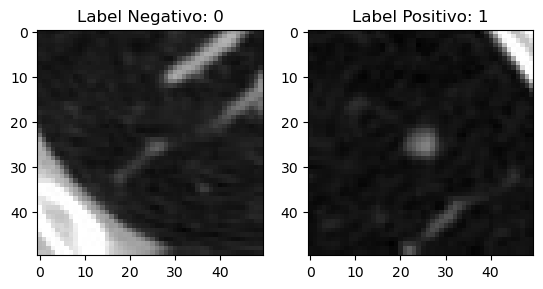

In [2]:
#observamos las imágenes
plt.subplot(1, 2, 1)
plt.title('Label Negativo: 0')
plt.imshow(cv2.imread('data\\images\\image_1054.jpg'))

plt.subplot(1, 2, 2)
plt.title('Label Positivo: 1')
plt.imshow(cv2.imread('data\\images\\image_13.jpg'))

plt.show()

## Pre-procesamiento de los Datos
Unir en un solo dataset las imagenes(paths) con sus labels

In [3]:
df = pd.read_csv('data\\labels.txt', sep=" ", header = None)
df.columns =['filepaths', 'labels']
df.head()

,filepaths,labels
0,data/images/image_189342.jpg,0
1,data/images/image_145102.jpg,0
2,data/images/image_31546.jpg,0
3,data/images/image_441280.jpg,1
4,data/images/image_215578.jpg,0


Tomar solo las primeras 1351 marcadas como negativas y todas las imagenes marcadas como positivas

In [4]:
labels_0 = df.loc[df['labels'] == 0]
labels_1 = df.loc[df['labels'] == 1]
labels_0 = labels_0[0:len(labels_1)]
labels = [labels_0, labels_1]
df2 = pd.concat(labels)
df = df2
df = shuffle(df).reset_index(drop = True)
print (df['labels'].value_counts())

1    1351
0    1351
Name: labels, dtype: int64


Separar el Dataset en:
* 70% training
* 15% validation
* 15% test

Y verificar la distribución de los datos por sus labels en cada dataset

In [5]:
# Se separan los datos en training, validacion y test
X_train, X_test, y_train, y_test = train_test_split(df['filepaths'], df['labels'], test_size=0.30, random_state=33)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, train_size=0.5, random_state=34)

print('Cantidad de datos en cada set\n')
print('Training:', len(y_train), '\t\t0:', y_train.value_counts()[0],', 1:' ,y_train.value_counts()[1])
print('Validacion:', len(y_val), '\t0:', y_val.value_counts()[0],', 1:' ,y_val.value_counts()[1])
print('Test:', len(y_test), '\t\t0:', y_test.value_counts()[0],', 1:' ,y_test.value_counts()[1])

Cantidad de datos en cada set

Training: 1891 		0: 959 , 1: 932
Validacion: 406 	0: 201 , 1: 205
Test: 405 		0: 191 , 1: 214


### Pre-procesamiento de las imagenes
Si bien las imagenes ya vienen de 50x50 pixeles y en escala de grises(50x50x1), es necesario pasarla a una representación de grises ya que por el formato de entrada se toman como RGB(50x50x3).
Se realiza este procesamiento para los sets de training y validación

In [6]:
IMG_SIZE = 50

def preprocessig_data(data):
    X = []
    for img_path in data:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Pasamos la imagen a escala de grises
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0 # normalizamos los pixeles de la imagen
        X.append(img)
    X = np.array(X)
    X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1)) #Hacemos un reshape de las imagenes
    return X

X_train = preprocessig_data(X_train)
X_val = preprocessig_data(X_val)

Se opta por una codificación en enteros, a continuación se hace uso de LabelEncoder para mantener las etiquetas 0 y 1

In [7]:
# Usamos labelEncoder para manejar los labels como numeros
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

## Red convolucional Compleja

* Capa convolucional de 32 neuronas con kernel 3 y activación Relu. Entrada de tamaño (50,50,1) tamaño de la imagen
* MaxPooling2D()
* Capa convolucional de 64 neuronas con kernel 3 y activación Relu
* MaxPooling2D()
* Capa convolucional de 128 neuronas con kernel 3 y activación Relu
* Capa convolucional de 256 neuronas con kernel 3 y activación Relu
* MaxPooling2D()
* Flatten()
* Capa densa de 128 neuronas y activación Relu
* Dropout(0.2)
* Capa densa de 64 neuronas y activación Relu
* Dropout(0.2)
* Capa densa de 32 neuronas y activación Relu
* Dropout(0.2)
* Capa densa de 16 neuronas y activación Relu
* Dropout(0.2)
* Capa densa de 1 neurona y activación Sigmoide dado a que la clasificación en binaria

Se usa el optimizador _RMSprop_, función de perdida _BinaryCrossentropy_ y como metricas se hace seguimiento de la precisión y el recall. Se opta por usar un checkpoint en el cual se guarda el mejor modelo

In [8]:
model_base = tf.keras.models.Sequential([

  Conv2D(32, kernel_size= (3,3), activation='relu', input_shape =(IMG_SIZE,IMG_SIZE,1)),
  MaxPooling2D(),

  Conv2D(64, kernel_size = (3,3), activation='relu'),
  MaxPooling2D(),
    
  Conv2D(128, kernel_size = (3,3), activation='relu'),

  Conv2D(256, kernel_size = (3,3), activation='relu'),
  MaxPooling2D(),
    
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.2),
    
  Dense(64, activation='relu'),
  Dropout(0.2),

  Dense(32, activation='relu'),
  Dropout(0.2),

  Dense(16, activation='relu'),
  Dropout(0.2),    
    
  Dense(1, activation= 'sigmoid') # Se tienen 2 posibles clases
])

callbacks = [
    ModelCheckpoint(
    filepath="modelos/checkpoint_model5a",
    save_best_only=True,
    monitor="val_loss")
]

model_base.compile(optimizer='RMSprop',loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['Precision', 'Recall'])
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

Realizar el entrenamiento

In [9]:
history_base = model_base.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=40, epochs = 200, callbacks=callbacks)

Epoch 1/200
48/48 [==============================] - ETA: 0s - loss: 0.6868 - precision: 0.5471 - recall: 0.7167

INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


48/48 [==============================] - 21s 344ms/step - loss: 0.6868 - precision: 0.5471 - recall: 0.7167 - val_loss: 0.6141 - val_precision: 0.6528 - val_recall: 0.9171
Epoch 2/200
48/48 [==============================] - ETA: 0s - loss: 0.6000 - precision: 0.7044 - recall: 0.7210

INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


48/48 [==============================] - 15s 318ms/step - loss: 0.6000 - precision: 0.7044 - recall: 0.7210 - val_loss: 0.5493 - val_precision: 0.6355 - val_recall: 0.9610
Epoch 3/200
48/48 [==============================] - ETA: 0s - loss: 0.5297 - precision: 0.7418 - recall: 0.8294

INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


48/48 [==============================] - 14s 297ms/step - loss: 0.5297 - precision: 0.7418 - recall: 0.8294 - val_loss: 0.4500 - val_precision: 0.7308 - val_recall: 0.9268
Epoch 4/200
48/48 [==============================] - 9s 189ms/step - loss: 0.4773 - precision: 0.7721 - recall: 0.8358 - val_loss: 0.6551 - val_precision: 0.9538 - val_recall: 0.3024
Epoch 5/200
48/48 [==============================] - 8s 169ms/step - loss: 0.4215 - precision: 0.8002 - recall: 0.8594 - val_loss: 0.7761 - val_precision: 0.9726 - val_recall: 0.3463
Epoch 6/200
48/48 [==============================] - ETA: 0s - loss: 0.3810 - precision: 0.8359 - recall: 0.8691

INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


48/48 [==============================] - 12s 250ms/step - loss: 0.3810 - precision: 0.8359 - recall: 0.8691 - val_loss: 0.3906 - val_precision: 0.7303 - val_recall: 0.9512
Epoch 7/200
48/48 [==============================] - 8s 170ms/step - loss: 0.3403 - precision: 0.8320 - recall: 0.9034 - val_loss: 0.4025 - val_precision: 0.8895 - val_recall: 0.7463
Epoch 8/200
48/48 [==============================] - 9s 191ms/step - loss: 0.3011 - precision: 0.8629 - recall: 0.9120 - val_loss: 0.3930 - val_precision: 0.8883 - val_recall: 0.8146
Epoch 9/200
48/48 [==============================] - 8s 172ms/step - loss: 0.2738 - precision: 0.8692 - recall: 0.9270 - val_loss: 0.9697 - val_precision: 0.9688 - val_recall: 0.3024
Epoch 10/200
48/48 [==============================] - ETA: 0s - loss: 0.2823 - precision: 0.8904 - recall: 0.9152

INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model5a\assets


48/48 [==============================] - 10s 220ms/step - loss: 0.2823 - precision: 0.8904 - recall: 0.9152 - val_loss: 0.3097 - val_precision: 0.9389 - val_recall: 0.8244
Epoch 11/200
48/48 [==============================] - 8s 167ms/step - loss: 0.2149 - precision: 0.9159 - recall: 0.9345 - val_loss: 0.4384 - val_precision: 0.9031 - val_recall: 0.8634
Epoch 12/200
48/48 [==============================] - 8s 166ms/step - loss: 0.1838 - precision: 0.9174 - recall: 0.9539 - val_loss: 0.4131 - val_precision: 0.9205 - val_recall: 0.7902
Epoch 13/200
48/48 [==============================] - 8s 170ms/step - loss: 0.1776 - precision: 0.9236 - recall: 0.9592 - val_loss: 0.4503 - val_precision: 0.9062 - val_recall: 0.8488
Epoch 14/200
48/48 [==============================] - 8s 168ms/step - loss: 0.1742 - precision: 0.9420 - recall: 0.9592 - val_loss: 0.3868 - val_precision: 0.8738 - val_recall: 0.8780
Epoch 15/200
48/48 [==============================] - 8s 165ms/step - loss: 0.1296 - precisi

Realizar el procesamiento de las imagenes del set de Test, y aplicar el Encoder

In [10]:
X_test= preprocessig_data(X_test)
y_test = le.transform(y_test)

### Evaluación del modelo con los Datos de Test

In [11]:
# Evaluacion del modelo con el conjunto de Test
score = model_base.evaluate(X_test, y_test)
print(f'Test loss: {score[0]}\nTest Precision: {score[1]}\nTest Recall: {score[2]}')

13/13 [==============================] - 1s 38ms/step - loss: 7.7678 - precision: 0.8451 - recall: 0.8925
Test loss: 7.767816066741943
Test Precision: 0.8451327681541443
Test Recall: 0.8925233483314514


### Visualización del proceso de Entrenamiento en terminos de Precisión y Loss

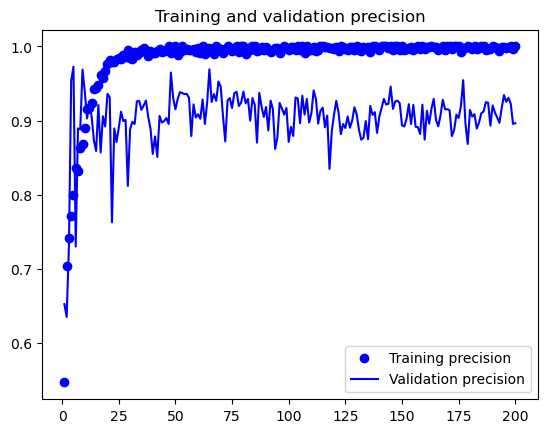

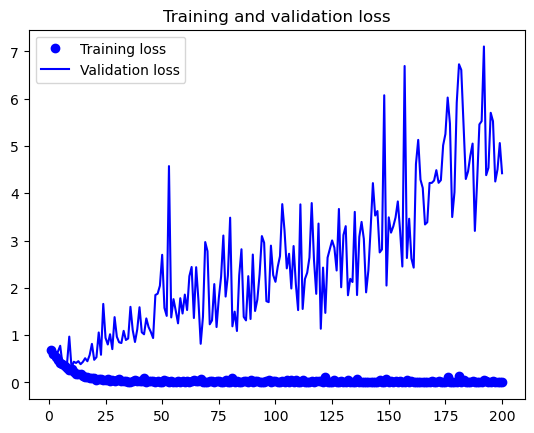

In [12]:
import matplotlib.pyplot as plt
precision = history_base.history["precision"]
val_precision = history_base.history["val_precision"]
loss = history_base.history["loss"]
val_loss = history_base.history["val_loss"]
epochs = range(1, len(precision) + 1)
plt.plot(epochs, precision, "bo", label="Training precision")
plt.plot(epochs, val_precision, "b", label="Validation precision")
plt.title("Training and validation precision")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Función para transformar la predicción del modelo a una de las clases (si se obtiene un valor mayor o igual a 0.5 se toma como positiva la clase, de lo contrario será negativa)

In [13]:
def getRealPrediction(y_aux):
    y_predicted = np.zeros(len(y_aux))
    for i in range(len(y_aux)):
        if y_aux[i] >= 0.5:
            y_predicted[i] = 1
        else:
            y_predicted[i] = 0
    return y_predicted

### Matriz de confusión del Modelo para los datos de Training y de Test

60/60 [==============================] - 2s 36ms/step
Matriz de Confusión Train


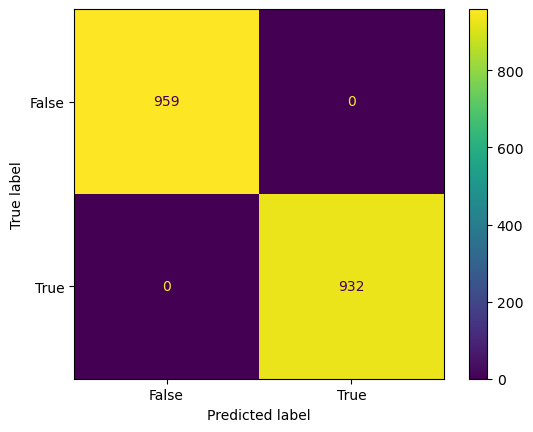

13/13 [==============================] - 0s 33ms/step
Matriz de Confusión Test


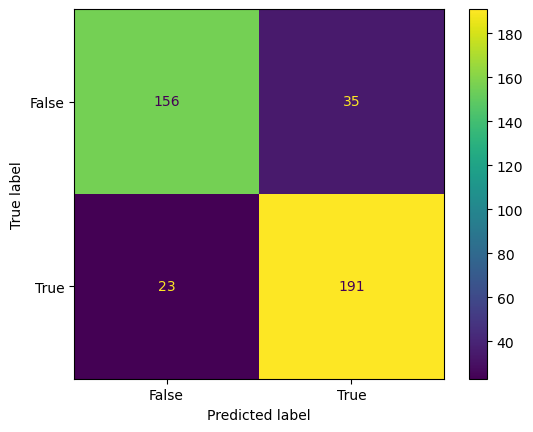

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_aux = model_base.predict(X_train)
y_predicted = getRealPrediction(y_aux)
confusion_matrix = metrics.confusion_matrix(y_train, y_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
print('Matriz de Confusión Train')
cm_display.plot()
plt.show()

y_aux = model_base.predict(X_test)
y_predicted = getRealPrediction(y_aux)
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
print('Matriz de Confusión Test')
cm_display.plot()
plt.show()

## Deploy del modelo guardado en el checkpoint

In [15]:
from tensorflow.keras.models import load_model
test_model = load_model("modelos/checkpoint_model5a")
IMG_SIZE = 50

def preprocessig_data(data):
    X = []
    for img_path in data:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Pasamos la imagen a escala de grises
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0 # normalizamos los pixeles de la imagen
        X.append(img)
    X = np.array(X)
    X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1)) #Hacemos un reshape de las imagenes
    return X

Prueba con una imagen marcada como Positiva

In [16]:
imagenPath = "data\\images\\image_13.jpg" # positiva
inputImage = preprocessig_data([imagenPath])
y_predicted = test_model(inputImage)
percentage = tf.gather(y_predicted, 0)[0].numpy()
real_val = getRealPrediction([percentage])[0]
print('percentage:',f'{round(percentage*100, 5)}%')
print('predicted:',real_val)

percentage: 84.56749%
predicted: 1.0


Prueba con una imagen marcada como Negativa

In [17]:
imagenPath = "data\\images\\image_1054.jpg" # negativa
inputImage = preprocessig_data([imagenPath])
y_predicted = test_model(inputImage)
percentage = tf.gather(y_predicted, 0)[0].numpy()
real_val = getRealPrediction([percentage])[0]
print('percentage:',f'{round(percentage*100, 5)}%')
print('predicted:',real_val)

percentage: 0.24688%
predicted: 0.0
